# Predicting Loan Defaults in Python
#### elliott.botwick@ibm.com

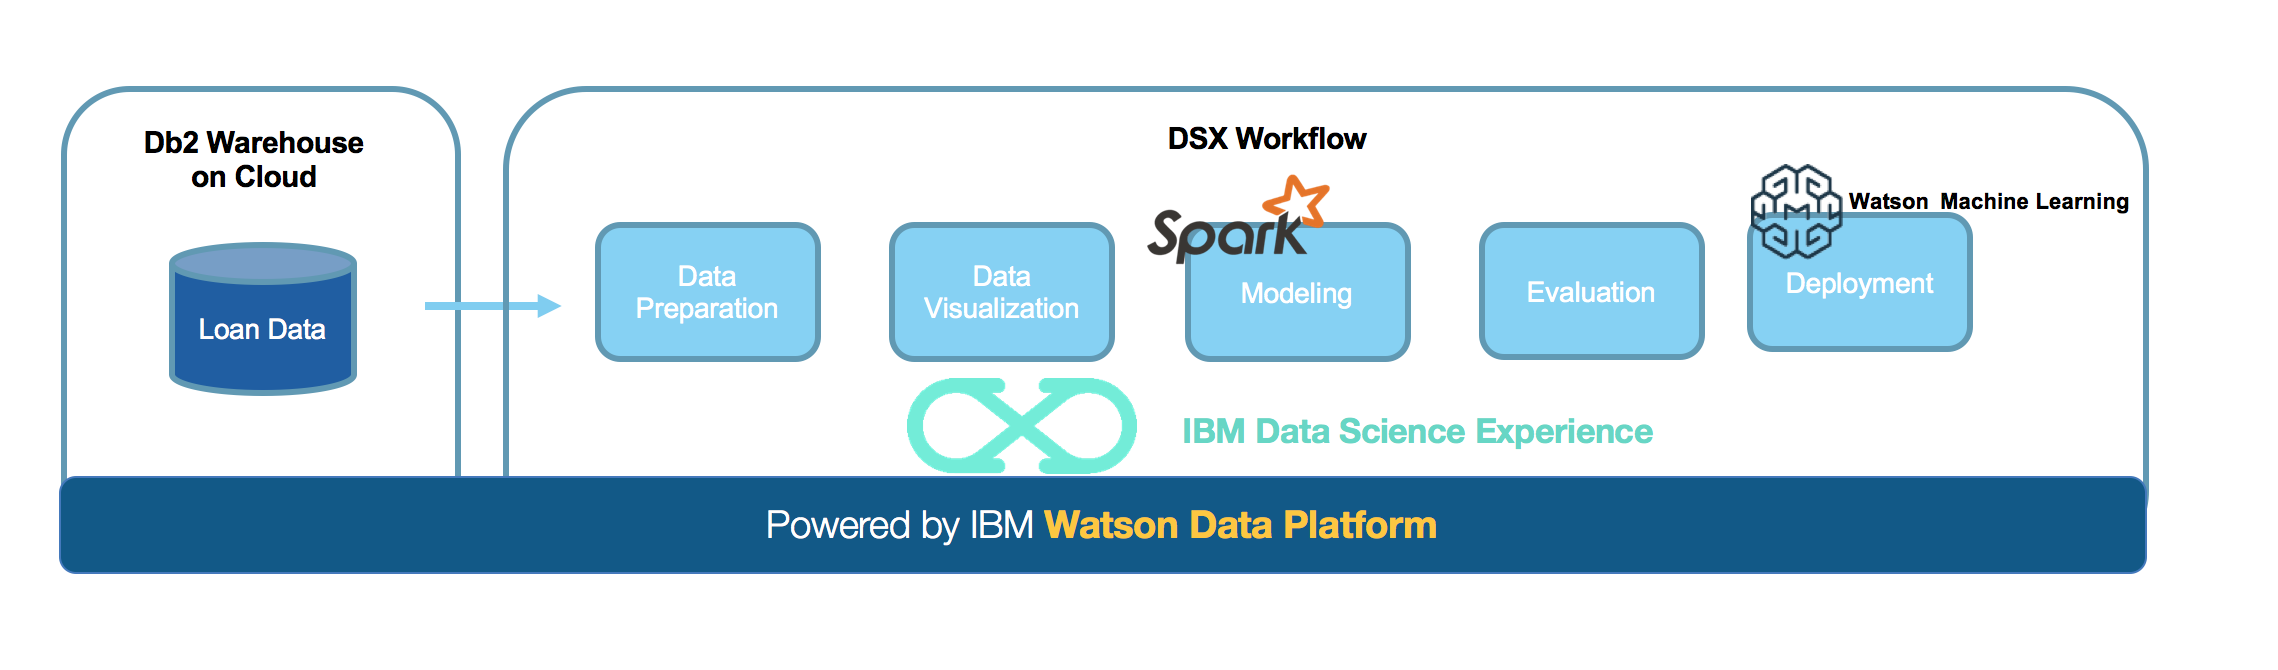

In [1]:
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np

In [2]:

from ibmdbpy import IdaDataBase, IdaDataFrame

# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook.
idadb_31aa2e6de3e140b49cb68911e8f07530 = IdaDataBase(dsn='DASHDB;Database=BLUDB;Hostname=dashdb-entry-yp-dal09-08.services.dal.bluemix.net;Port=50000;PROTOCOL=TCPIP;UID=dash5213;PWD=1RJTPNMcMSFo')

LoanHistory = IdaDataFrame(idadb_31aa2e6de3e140b49cb68911e8f07530, 'DASH5213.LOAN_HISTORY').as_dataframe()
# You can close the database connection with the following code. Please keep the comment line with the @hidden_cell tag,
# because the close function displays parts of the credentials.
# @hidden_cell
# idadb_31aa2e6de3e140b49cb68911e8f07530.close()
# To learn more about the ibmdby package, please read the documentation: http://pythonhosted.org/ibmdbpy/


In [8]:
print ("There are ", str(len(LoanHistory)), " observations in the customer history dataset.")
print ("There are ",str(len(LoanHistory.columns))," attributes in the dataset.")

print  ("\n-*-*-*-*-*-*-*-*-  Sample View of Dataset  -*-*-*-*-*-*-*-*-\n")
LoanHistory.head()

There are  1000  observations in the customer history dataset.
There are  27  attributes in the dataset.

-*-*-*-*-*-*-*-*-  Sample View of Dataset  -*-*-*-*-*-*-*-*-



,MERCHANT,ACCT_STATUS_K_USD,CONTRACT_DURATION_MONTH,HISTORY,CREDIT_PROGRAM,AMOUNT_K_USD,ACCOUNT_TYPE,ACCT_AGE,STATE,IS_URBAN,...,ESTABLISHED_MONTH,OTHER_INSTALL_PLAN,RENT,OWN_RESIDENCE,NUMBER_CREDITS,RFM_SCORE,BRANCHES,TELEPHONE,SHIP_INTERNATIONAL,IS_DEFAULT
0,799,NONE,24,DELAY IN PAST,NEW CAR,717,UNKNOWN/NONE,above 7 YRS,NY,NO,...,54,NO,NO,YES,2,3,1,YES,NO,No
1,800,0 to 200 USD,9,EXISTING CREDITS PAID BACK,NEW CAR,1549,UNKNOWN/NONE,up to 1 YR,NY,NO,...,35,NO,NO,YES,1,1,1,NO,NO,No
2,801,NONE,24,CRITICAL ACCOUNT,EDUCATION,1597,up to 100 K USD,above 7 YRS,NY,NO,...,54,NO,NO,NO,2,3,2,NO,NO,No
3,802,0 to 200 USD,18,CRITICAL ACCOUNT,ELECTRONICS,1795,up to 100 K USD,above 7 YRS,CT,NO,...,48,YES,YES,NO,2,2,1,YES,NO,No
4,803,0 USD,20,CRITICAL ACCOUNT,FURNITURE,4272,up to 100 K USD,above 7 YRS,PA,NO,...,24,NO,NO,YES,2,3,1,NO,NO,No


In [9]:
LoanHistory.describe()

,MERCHANT,CONTRACT_DURATION_MONTH,AMOUNT_K_USD,ESTABLISHED_MONTH,NUMBER_CREDITS,RFM_SCORE,BRANCHES
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,20.903000,3271.258000,35.546000,1.407000,2.904000,1.155000
std,288.819436,12.058814,2822.736876,11.375469,0.577654,0.653614,0.362086
min,1.000000,4.000000,250.000000,19.000000,1.000000,1.000000,1.000000
25%,250.750000,12.000000,1365.500000,27.000000,1.000000,3.000000,1.000000
50%,500.500000,18.000000,2319.500000,33.000000,1.000000,3.000000,1.000000
75%,750.250000,24.000000,3972.250000,42.000000,2.000000,3.000000,1.000000
max,1000.000000,72.000000,18424.000000,75.000000,4.000000,4.000000,2.000000


In [10]:
#LoanHistory['IS_DEFAULT'] = LoanHistory.IS_DEFAULT.astype('category')
LoanHistory['DefaultNum'] = ''

for i in range (0,LoanHistory.shape[0]):
    if (LoanHistory.IS_DEFAULT[i] == "No"):
        LoanHistory.DefaultNum[i] = 0
    else:
        LoanHistory.DefaultNum[i] = 1

/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
#LoanHistory['IS_DEFAULT'] = LoanHistory.IS_DEFAULT.astype('category')
LoanHistory['DefaultNum'] = LoanHistory.DefaultNum.astype('int')
print("IS_DEFAULT data type ")
print(LoanHistory.IS_DEFAULT.dtype)
print("DefaultNum data type ")
print(LoanHistory.DefaultNum.dtype)


IS_DEFAULT data type 
object
DefaultNum data type 
int64


In [12]:
print("Importing opensource vizualization library pixiedust!\n")
import pixiedust as pix

Importing opensource vizualization library pixiedust!

Pixiedust database opened successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


In [11]:
pix.display(LoanHistory)

Exception: Unable to get caller text

In [14]:
pix.display(LoanHistory)

Exception: Unable to get caller text

## Feature Selection

In [13]:
corrDF = LoanHistory.corr()
corrDF.head(8)

,MERCHANT,CONTRACT_DURATION_MONTH,AMOUNT_K_USD,ESTABLISHED_MONTH,NUMBER_CREDITS,RFM_SCORE,BRANCHES,DefaultNum
MERCHANT,1.000000,0.030788,0.013488,-0.010096,0.022838,-0.027345,0.026662,0.034606
CONTRACT_DURATION_MONTH,0.030788,1.000000,0.624984,-0.036136,-0.011284,0.210910,-0.023834,0.214927
AMOUNT_K_USD,0.013488,0.624984,1.000000,0.032716,0.020795,0.285385,0.017142,0.154739
ESTABLISHED_MONTH,-0.010096,-0.036136,0.032716,1.000000,0.149254,0.015673,0.118201,-0.091127
NUMBER_CREDITS,0.022838,-0.011284,0.020795,0.149254,1.000000,-0.026321,0.109667,-0.045732
RFM_SCORE,-0.027345,0.210910,0.285385,0.015673,-0.026321,1.000000,-0.093559,0.032735
BRANCHES,0.026662,-0.023834,0.017142,0.118201,0.109667,-0.093559,1.000000,-0.003015
DefaultNum,0.034606,0.214927,0.154739,-0.091127,-0.045732,0.032735,-0.003015,1.000000


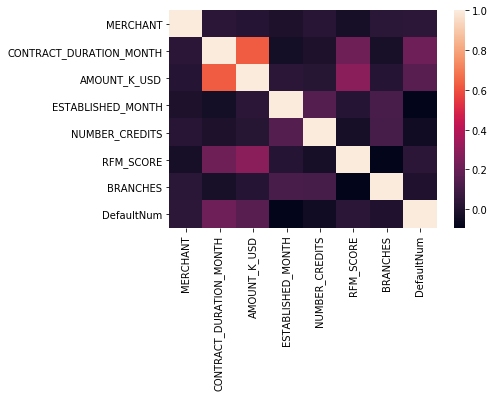

In [14]:
import seaborn as sns
sns.heatmap(corrDF, 
            xticklabels=corrDF.columns.values,
            yticklabels=corrDF.columns.values)

In [15]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [38]:
LoanPred = pd.DataFrame(index=[LoanHistory.CONTRACT_DURATION_MONTH, LoanHistory.AMOUNT_K_USD, LoanHistory.STATE, LoanHistory.CREDIT_PROGRAM, LoanHistory.DefaultNum], columns = ["CONTRACT_DURATION_MONTH", "AMOUNT_K_USD", "STATE", "CREDIT_PROGRAM", "DefaultNum"] )
#Keep only 
#Contract Duration in Months
#Amount of loan 
#State
#Credit program loan is for
#Default status

#Drop everything else
LoanSp = sqlContext.createDataFrame(LoanHistory)
LoanSp = LoanSp.drop('MERCHANT',
 'ACCT_STATUS_K_USD',
 'HISTORY',
 'ACCOUNT_TYPE',
 'ACCT_AGE',
 'IS_URBAN',
 'IS_XBORDER',
 'SELF_REPORTED_ASMT',
 'CO_APPLICANT',
 'GUARANTOR',
 'PRESENT_RESIDENT',
 'OWN_REAL_ESTATE',
 'PROP_UNKN',
 'ESTABLISHED_MONTH',
 'OTHER_INSTALL_PLAN',
 'RENT',
 'OWN_RESIDENCE',
 'NUMBER_CREDITS',
 'RFM_SCORE',
 'BRANCHES',
 'TELEPHONE',
 'IS_DEFAULT',
 'SHIP_INTERNATIONAL')

In [39]:
LoanSp.describe()

DataFrame[summary: string, CONTRACT_DURATION_MONTH: string, CREDIT_PROGRAM: string, AMOUNT_K_USD: string, STATE: string, DefaultNum: string]

In [42]:
trainingData, testData = LoanSp.randomSplit([0.7, 0.3], seed = 492)
print ("Training set size: ", str(trainingData.count()))
print ("Testing set size: ", str(testData.count()))
print ("Distribution of Default and Non-Default in trainingData is: " , trainingData.groupBy(LoanSp.DefaultNum).count().take(3))

Training set size:  660
Testing set size:  340
Distribution of Default and Non-Default in trainingData is:  [Row(DefaultNum=0, count=465), Row(DefaultNum=1, count=195)]


In [43]:
stringIndexer_state = StringIndexer(inputCol="STATE", outputCol="STATE_IX")
stringIndexer_credprog = StringIndexer(inputCol="CREDIT_PROGRAM", outputCol="CREDIT_PROGRAM_IX")

In [44]:
vectorAssembler_features = VectorAssembler(inputCols=["CONTRACT_DURATION_MONTH", "STATE_IX", "CREDIT_PROGRAM_IX", "AMOUNT_K_USD"], outputCol="features")
labelIndexer = StringIndexer(inputCol='DefaultNum', outputCol='label').fit(LoanSp)

In [46]:
# instantiate the algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[stringIndexer_state, stringIndexer_credprog,labelIndexer, vectorAssembler_features, rf, labelConverter])
#pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6,labelIndexer, assembler, rf, labelConverter])

In [47]:
# Split data into train and test datasets
train, test = LoanSp.randomSplit([0.7,0.3], seed=12)
train.cache()
test.cache()

DataFrame[CONTRACT_DURATION_MONTH: bigint, CREDIT_PROGRAM: string, AMOUNT_K_USD: bigint, STATE: string, DefaultNum: bigint]

In [48]:
# Build models
model = pipeline.fit(train)

In [49]:
model.transform(test)

DataFrame[CONTRACT_DURATION_MONTH: bigint, CREDIT_PROGRAM: string, AMOUNT_K_USD: bigint, STATE: string, DefaultNum: bigint, STATE_IX: double, CREDIT_PROGRAM_IX: double, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double, predictedLabel: string]

In [52]:
results = model.transform(test)
results.toPandas().head(6)

,CONTRACT_DURATION_MONTH,CREDIT_PROGRAM,AMOUNT_K_USD,STATE,DefaultNum,STATE_IX,CREDIT_PROGRAM_IX,label,features,rawPrediction,probability,prediction,predictedLabel
0,6,EDUCATION,448,NY,1,0.0,6.0,1.0,"[6.0, 0.0, 6.0, 448.0]","[15.1200188431, 4.87998115692]","[0.756000942154, 0.243999057846]",0.0,0
1,6,ELECTRONICS,368,NY,0,0.0,0.0,0.0,"[6.0, 0.0, 0.0, 368.0]","[17.0217942611, 2.97820573889]","[0.851089713055, 0.148910286945]",0.0,0
2,6,ELECTRONICS,484,CT,0,2.0,0.0,0.0,"[6.0, 2.0, 0.0, 484.0]","[17.9206868404, 2.07931315961]","[0.89603434202, 0.10396565798]",0.0,0
3,6,ELECTRONICS,590,CT,0,2.0,0.0,0.0,"[6.0, 2.0, 0.0, 590.0]","[17.9206868404, 2.07931315961]","[0.89603434202, 0.10396565798]",0.0,0
4,6,ELECTRONICS,683,NJ,0,1.0,0.0,0.0,"[6.0, 1.0, 0.0, 683.0]","[18.269675751, 1.73032424898]","[0.913483787551, 0.0865162124488]",0.0,0
5,6,ELECTRONICS,700,NY,0,0.0,0.0,0.0,"[6.0, 0.0, 0.0, 700.0]","[17.0217942611, 2.97820573889]","[0.851089713055, 0.148910286945]",0.0,0


In [55]:
print ("Precision model =", "%.2f" %(results.filter(results.label == results.prediction).count() / float(results.count())))

Precision model = 0.69


In [56]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print ("Area under ROC curve =", "%.2f" %(evaluator.evaluate(results)))

Area under ROC curve = 0.55


In [72]:
LoanSp.toPandas().describe(include = 'all')

,CONTRACT_DURATION_MONTH,CREDIT_PROGRAM,AMOUNT_K_USD,STATE,DefaultNum
count,1000.000000,1000,1000.000000,1000,1000.000000
unique,NaN,7,NaN,4,NaN
top,NaN,ELECTRONICS,NaN,NY,NaN
freq,NaN,280,NaN,476,NaN
mean,20.903000,NaN,3271.258000,NaN,0.300000
std,12.058814,NaN,2822.736876,NaN,0.458487
min,4.000000,NaN,250.000000,NaN,0.000000
25%,12.000000,NaN,1365.500000,NaN,0.000000
50%,18.000000,NaN,2319.500000,NaN,0.000000
75%,24.000000,NaN,3972.250000,NaN,1.000000


In [57]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
wml_credentials = {
  "username": "d77325ed-0349-459f-89a6-e6d8e758bdf2",
  "password": "71852db4-0998-4491-bed8-321d946ca179",
  "instance_id": "cb370dbb-b973-4c22-95fa-f5a770b1532d",
  "url": "https://us-south.ml.cloud.ibm.com"
}

client = WatsonMachineLearningAPIClient(wml_credentials)

model_details = client.repository.store_model( model, 'LoanModel', training_data=train, pipeline=pipeline )

In [23]:
from sklearn import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

  Could not find a version that satisfies the requirement tran_test_split (from versions: )
No matching distribution found for tran_test_split


ImportError: cannot import name 'train_test_split'